Train HOG Classifier
===


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lesson_functions import *
from sklearn.utils import shuffle

### Load splitted data sets from pickle file

In [2]:
# Load the training validation and test data
data_file = 'data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars_train = data['cars_train']
cars_val   = data['cars_val']
cars_test  = data['cars_test']
notcars_train = data['notcars_train']
notcars_val   = data['notcars_val']
notcars_test  = data['notcars_test']

In [3]:
print('Number of samples in cars training set: ', len(cars_train))
print('Number of samples in cars validation set: ', len(cars_val))
print('Number of samples in cars test set: ', len(cars_test))

print('Number of samples in notcars training set: ', len(notcars_train))
print('Number of samples in notcars validation set: ', len(notcars_val))
print('Number of samples in notcars test set: ', len(notcars_test))

Number of samples in cars training set:  6152
Number of samples in cars validation set:  1759
Number of samples in cars test set:  881
Number of samples in notcars training set:  6277
Number of samples in notcars validation set:  1794
Number of samples in notcars test set:  897


### Two classes are quite balanced

In [4]:
print('Number of samples in cars set: ', len(cars_train)+len(cars_val)+len(cars_test))
print('Number of samples in notcars set: ', len(notcars_train)+len(notcars_val)+len(notcars_test))

Number of samples in cars set:  8792
Number of samples in notcars set:  8968


### Extract features from image files 

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    print('color_space: ', color_space)
    print('spatial_size: ', spatial_size)
    print('hist_bins: ', hist_bins)
    print('orient: ', orient)
    print('pix_per_cell: ', pix_per_cell)
    print('cell_per_block: ', cell_per_block)
    print('hog_channel: ', hog_channel)
    print('spatial_feat: ', spatial_feat)
    print('hist_feat: ', hist_feat)
    print('hog_feat: ', hog_feat)
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)
        
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    
        features.append(img_features)
        
    # Return list of feature vectors
    return features

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t1=time.time()

cars_train_feats = extract_features(cars_train, color_space, spatial_size, hist_bins, orient,
                                      pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_train_feats = extract_features(notcars_train, color_space, spatial_size, hist_bins, orient,
                                         pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

cars_val_feats = extract_features(cars_val, color_space, spatial_size, hist_bins, orient,
                                      pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_val_feats = extract_features(notcars_val, color_space, spatial_size, hist_bins, orient,
                                         pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

cars_test_feats = extract_features(cars_test, color_space, spatial_size, hist_bins, orient,
                                      pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_test_feats = extract_features(notcars_test, color_space, spatial_size, hist_bins, orient,
                                         pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

t2 = time.time()
print(round(t2-t1, 2), 'second to extract features (HOG,spatial and color features).')

color_space:  YCrCb
spatial_size:  (32, 32)
hist_bins:  32
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_feat:  True
hist_feat:  True
hog_feat:  True
color_space:  YCrCb
spatial_size:  (32, 32)
hist_bins:  32
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_feat:  True
hist_feat:  True
hog_feat:  True
color_space:  YCrCb
spatial_size:  (32, 32)
hist_bins:  32
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_feat:  True
hist_feat:  True
hog_feat:  True
color_space:  YCrCb
spatial_size:  (32, 32)
hist_bins:  32
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_feat:  True
hist_feat:  True
hog_feat:  True
color_space:  YCrCb
spatial_size:  (32, 32)
hist_bins:  32
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_feat:  True
hist_feat:  True
hog_feat:  True
color_space:  YCrCb
spatial_size:  (32, 32)
hist_bins:  32
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_chann

### Combine and Normalize Features

In [7]:
# Create an array stack of feature vectors
X = np.vstack((cars_train_feats, cars_val_feats, cars_test_feats,
                  notcars_train_feats, notcars_val_feats, notcars_test_feats)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [8]:
assert(len(cars_train_feats) == len(cars_train))
assert(len(cars_val_feats) == len(cars_val))
assert(len(cars_test_feats) == len(cars_test))

assert(len(notcars_train_feats) == len(notcars_train))
assert(len(notcars_val_feats) == len(notcars_val))
assert(len(notcars_test_feats) == len(notcars_test))

n_cars_train = len(cars_train)
n_cars_val   = len(cars_val)
n_cars_test  = len(cars_test)

n_notcars_train = len(notcars_train)
n_notcars_val   = len(notcars_val)
n_notcars_test  = len(notcars_test)

c1 = n_cars_train
c2 = c1 + n_cars_val
c3 = c2 + n_cars_test
nc4 = c3 + n_notcars_train
nc5 = nc4 + n_notcars_val

cars_train_feats, cars_val_feats, cars_test_feats = scaled_X[:c1], scaled_X[c1:c2], scaled_X[c2:c3]
notcars_train_feats, notcars_val_feats, notcars_test_feats = scaled_X[c3:nc4], scaled_X[nc4:nc5], scaled_X[nc5:]

assert(len(cars_train_feats) == n_cars_train)
assert(len(cars_val_feats) == n_cars_val)
assert(len(cars_test_feats) == n_cars_test)

assert(len(notcars_train_feats) == n_notcars_train)
assert(len(notcars_val_feats) == n_notcars_val)
assert(len(notcars_test_feats) == n_notcars_test)

X_train = np.vstack((cars_train_feats, notcars_train_feats))
X_val = np.vstack((cars_val_feats, notcars_val_feats))
X_test = np.vstack((cars_test_feats, notcars_test_feats))

# Define the labels vector
y_train = np.hstack((np.ones(n_cars_train), np.zeros(n_notcars_train)))
y_val = np.hstack((np.ones(n_cars_val), np.zeros(n_notcars_val)))
y_test = np.hstack((np.ones(n_cars_test), np.zeros(n_notcars_test)))
       
assert(len(X_train) == len(y_train))
assert(len(X_val) == len(y_val))
assert(len(X_test) == len(y_test))

print('Number of samples in training set: ', len(X_train))
print('Number of samples in validation set: ', len(X_val))
print('Number of samples in test set: ', len(X_test))

# Shuffle samples in set
random_state = 13
X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
X_val, y_val = shuffle(X_val, y_val, random_state=random_state)
X_test, y_test = shuffle(X_test, y_test, random_state=random_state)

Number of samples in training set:  12429
Number of samples in validation set:  3553
Number of samples in test set:  1778


### Save prepared train / validation / test sets to pickle file

In [9]:
# Save the data for easy access
pickle_file = 'HOGClassifierData.p'
print('Saving features/labels to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'X_train': X_train,
                'X_val': X_val,
                'X_test': X_test,
                
                'y_train': y_train,
                'y_val': y_val,
                'y_test': y_test                
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save classifier data to', pickle_file, ':', e)
    raise
    
print('Classifier data cached in pickle file.')

Saving features/labels to pickle file...
Classifier data cached in pickle file.


### Train SVM Classifier

In [9]:
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 8460
15.83 Seconds to train SVC...
Validation Accuracy of SVC =  0.9572
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.
  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.]
For these 100 labels:  [ 0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.]
0.00501 Seconds to predict 100 labels with SVC


### Save HOG Classifier to file

In [10]:
pickle_file = 'HOGClassifier.p'
print('Saving classiifier to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {   'svc':svc, 
                'scaler': X_scaler,

                'color_space': color_space,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat             
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save classifier to', pickle_file, ':', e)
    raise
print('Classifier saved in pickle file.')

Saving classiifier to pickle file...
Classifier saved in pickle file.


### Test prediction

orient:  9
pix_per_cell:  8
cell_per_block:  2
spatial_size:  (32, 32)
hist_bins:  32
0.25953 Seconds to detect using scale: 1.5


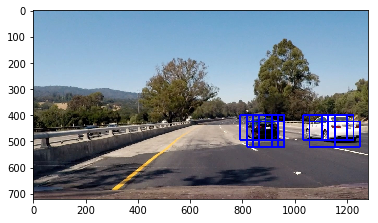

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *
%matplotlib inline

dist_pickle = pickle.load( open("HOGClassifier.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print('orient: ', orient)
print('pix_per_cell: ', pix_per_cell)
print('cell_per_block: ', cell_per_block)
print('spatial_size: ', spatial_size)
print('hist_bins: ', hist_bins)

#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test5.jpg')
#img = mpimg.imread('test_images/test6.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
t=time.time()

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to detect using scale:', scale)

plt.imshow(out_img)